In [27]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers,regularizers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

from tensorflow.config import list_physical_devices

#check the GPU use
print("Num GPUs Available: ", len(list_physical_devices('GPU')))


Num GPUs Available:  1


In [2]:
data_dir = "../raw_data/images_png/"
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
VALIDATION_SPLIT = 0.3
BATCH_SIZE = 32
IMAGE_SIZE = (64, 376)
SHUFLE_VALUE = True
RANDOM_SEED = 42
TEST_SIZE_PART = 1

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=VALIDATION_SPLIT,
  subset="training",
  seed=RANDOM_SEED,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE,
  color_mode = "grayscale",
  shuffle = SHUFLE_VALUE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=VALIDATION_SPLIT,
  subset="validation",
  seed=RANDOM_SEED,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE,
  color_mode = "grayscale",
  shuffle = SHUFLE_VALUE)


Found 38044 files belonging to 34 classes.
Using 26631 files for training.


2023-12-01 07:55:33.565558: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8697 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5


Found 38044 files belonging to 34 classes.
Using 11413 files for validation.


In [4]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((TEST_SIZE_PART*val_batches) // 3)
val_ds = val_ds.skip((TEST_SIZE_PART*val_batches) // 3)


In [6]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)


['banswa', 'barswa', 'calqua', 'cangoo', 'caster1', 'comloo', 'comrav', 'comred', 'comter', 'eargre', 'eucdov', 'eursta', 'gadwal', 'gnwtea', 'goleag', 'greegr', 'hergul', 'horlar', 'houspa', 'mallar3', 'merlin', 'norsho', 'osprey', 'pecsan', 'perfal', 'redcro', 'ribgul', 'rinduc', 'rocpig', 'rudduc', 'sheowl', 'silence', 'snobun', 'tunswa']


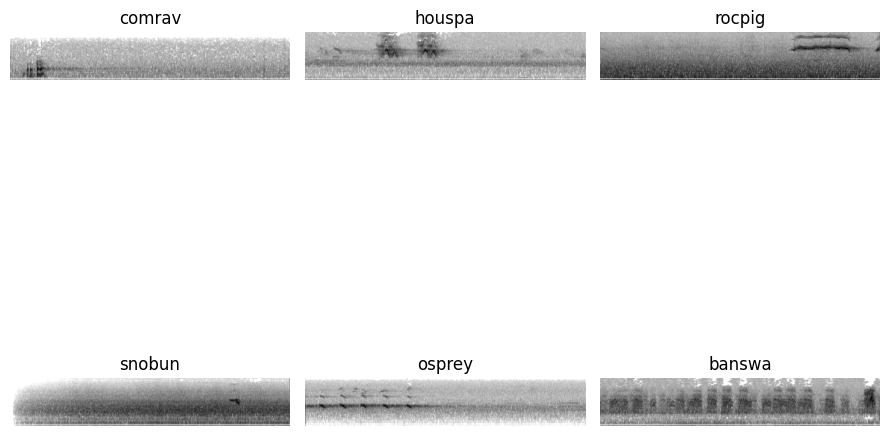

In [8]:
plt.figure(figsize=(9, 6))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis("off")
    plt.tight_layout()


In [9]:
model_1 = Sequential([
  layers.Rescaling(1./255, input_shape=(64, 376, 1)),
  layers.Conv2D(64, (2,2), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(64, (2,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.04),
  layers.Conv2D(64, (3,2), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, (5,5), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dense(1568, activation='relu'),
  layers.Dense(500, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [10]:
model_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 376, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 64, 376, 64)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 188, 64)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 188, 64)       24640     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 94, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 16, 94, 64)        0

In [11]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/

# We will store the logs in a folder (one folder per fit)
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [12]:
from birdsong.utils import create_folder_if_not_exists

# Create a callback that saves the model's weights
checkpoint_folder_path = "../models_checkpoints/raman_model_test_baseline/"
create_folder_if_not_exists(checkpoint_folder_path)

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = os.path.join(checkpoint_folder_path,"cp-{epoch:04d}.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)

PATIENCE = 6

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=PATIENCE)



# Calculate the number of batches per epoch
import math
n_batches = len(train_ds) / BATCH_SIZE
n_batches = math.ceil(n_batches)    # round up the number of batches to the nearest whole integer

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=50*n_batches)


In [15]:
""""""
model_1 = Sequential([
  layers.Rescaling(1./255, input_shape=(64, 376, 1)),

  layers.Conv2D(64, (2,2), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(64, (2,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(64, (3,2), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, (5,5), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.24),
  layers.Flatten(),
  layers.Dense(1568, activation='relu'),
  layers.Dense(500, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [16]:
model_1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 64, 376, 1)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 376, 64)       320       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 32, 188, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 188, 64)       24640     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 16, 94, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 94, 64)       

In [17]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/

# We will store the logs in a folder (one folder per fit)
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [18]:

epochs=30

# Save the weights using the `checkpoint_path` format
model_1.save_weights(checkpoint_path.format(epoch=0))

history = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[es,tensorboard_callback,cp_callback])


Epoch 1/30


/home/sheshka/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-12-01 08:01:29.285991: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


790/833 [===========================>..] - ETA: 1s - loss: 2.6858 - accuracy: 0.2542
Epoch 1: saving model to ../models_checkpoints/raman_model_test_baseline/cp-0001.ckpt
833/833 [==============================] - 58s 67ms/step - loss: 2.6557 - accuracy: 0.2625 - val_loss: 2.1100 - val_accuracy: 0.4135
Epoch 2/30
833/833 [==============================] - 26s 31ms/step - loss: 1.8078 - accuracy: 0.4965 - val_loss: 1.6285 - val_accuracy: 0.5452
Epoch 3/30
473/833 [================>.............] - ETA: 10s - loss: 1.4993 - accuracy: 0.5810
Epoch 3: saving model to ../models_checkpoints/raman_model_test_baseline/cp-0003.ckpt
833/833 [==============================] - 26s 31ms/step - loss: 1.4346 - accuracy: 0.5967 - val_loss: 1.3329 - val_accuracy: 0.6320
Epoch 4/30
833/833 [==============================] - 26s 31ms/step - loss: 1.1786 - accuracy: 0.6658 - val_loss: 1.1882 - val_accuracy: 0.6731
Epoch 5/30
157/833 [====>.........................] - ETA: 19s - loss: 1.0479 - accuracy: 0.

In [20]:
%tensorboard --logdir logs/fit

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


Reusing TensorBoard on port 6006 (pid 72603), started 0:00:07 ago. (Use '!kill 72603' to kill it.)

In [21]:
def plot_history(history, metric_label, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name

    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(min(history.history['loss']) * 0.8,
                 max(history.history['loss']) * 1.1,)
    ax1.set_title('loss')
    ax1.legend()
    ax1.set_xlabel('epochs')
    ax1.spines.right.set_visible(False)
    ax1.spines.top.set_visible(False)

    ax2.plot(history.history[metric_label], label='train ' + metric_label  + exp_name)
    ax2.plot(history.history['val_'+metric_label], label='val ' + metric_label  + exp_name)
    ax2.set_ylim(min(history.history[metric_label]) * 0.8,
                 max(history.history[metric_label]) * 1.1)
    ax2.set_title(metric_label.capitalize())
    ax2.legend()
    ax2.set_xlabel('epochs')
    ax2.spines.right.set_visible(False)
    ax2.spines.top.set_visible(False)
    return (ax1, ax2)


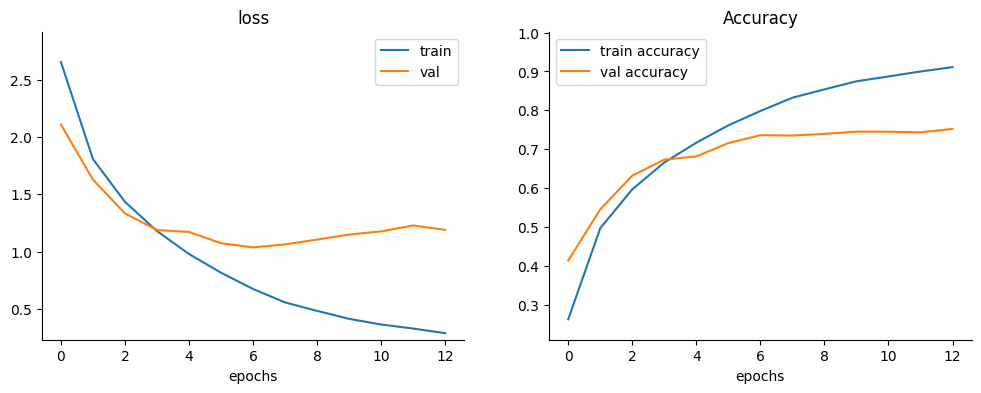

In [22]:
plot_history(history, 'accuracy', title='', axs=None, exp_name="")
plt.show()


In [23]:
predictions = model_1.predict(test_ds)


119/119 [==============================] - 1s 5ms/step


In [24]:
(n_rows, n_columns) = predictions.shape
score_pred = []
for n in range(n_rows):
    score_pred.append([np.argmax(predictions[n]),
                       class_names[np.argmax(predictions[n])],"this song most likely belongs to {} with a {:.2f} percent confidence."\
                       .format(class_names[np.argmax(predictions[n])], 100 * np.max(predictions[n]))])

df = pd.DataFrame(score_pred, columns=["prediction", "class", "description"])


In [25]:
df


,prediction,class,description
0,6,comrav,this song most likely belongs to comrav with a...
1,19,mallar3,this song most likely belongs to mallar3 with ...
2,13,gnwtea,this song most likely belongs to gnwtea with a...
3,19,mallar3,this song most likely belongs to mallar3 with ...
4,12,gadwal,this song most likely belongs to gadwal with a...
...,...,...,...
3803,13,gnwtea,this song most likely belongs to gnwtea with a...
3804,6,comrav,this song most likely belongs to comrav with a...
3805,14,goleag,this song most likely belongs to goleag with a...
3806,2,calqua,this song most likely belongs to calqua with a...


In [26]:
(loss_evaluate,accuracy_evaluate) =  model_1.evaluate(test_ds)


119/119 [==============================] - 1s 7ms/step - loss: 1.1889 - accuracy: 0.7484


In [32]:
reg_l2 = regularizers.L2(0.01)

model_2 = Sequential([
  layers.Rescaling(1./255, input_shape=(64, 376, 1)),
  layers.Conv2D(64, (2,2), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.04),
  layers.Conv2D(64, (2,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.04),
  layers.Conv2D(64, (3,2), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, (4,4), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dense(1568, activation='relu',activity_regularizer=reg_l2),
  layers.Dense(500, activation='relu',kernel_regularizer=reg_l2),
  layers.Dense(num_classes, activation='softmax')
])

model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [33]:
from birdsong.utils import create_folder_if_not_exists

# Create a callback that saves the model's weights
checkpoint_folder_path = "../models_checkpoints/raman_model_test_baseline_2/"
create_folder_if_not_exists(checkpoint_folder_path)

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = os.path.join(checkpoint_folder_path,"cp-{epoch:04d}.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)

PATIENCE = 6

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=PATIENCE)



# Calculate the number of batches per epoch
import math
n_batches = len(train_ds) / BATCH_SIZE
n_batches = math.ceil(n_batches)    # round up the number of batches to the nearest whole integer

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=50*n_batches)


In [34]:

epochs=30

# Save the weights using the `checkpoint_path` format
model_2.save_weights(checkpoint_path.format(epoch=0))

history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[es,tensorboard_callback])


Epoch 1/30


2023-12-01 08:24:03.142888: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


833/833 [==============================] - 30s 33ms/step - loss: 3.1050 - accuracy: 0.2102 - val_loss: 2.4919 - val_accuracy: 0.3699
Epoch 2/30
833/833 [==============================] - 27s 33ms/step - loss: 2.2972 - accuracy: 0.4185 - val_loss: 2.0940 - val_accuracy: 0.4852
Epoch 3/30
833/833 [==============================] - 28s 33ms/step - loss: 1.9582 - accuracy: 0.5271 - val_loss: 1.8353 - val_accuracy: 0.5644
Epoch 4/30
833/833 [==============================] - 27s 33ms/step - loss: 1.7313 - accuracy: 0.5943 - val_loss: 1.7043 - val_accuracy: 0.6072
Epoch 5/30
833/833 [==============================] - 27s 33ms/step - loss: 1.5578 - accuracy: 0.6439 - val_loss: 1.5905 - val_accuracy: 0.6410
Epoch 6/30
833/833 [==============================] - 27s 33ms/step - loss: 1.4215 - accuracy: 0.6827 - val_loss: 1.5318 - val_accuracy: 0.6577
Epoch 7/30
833/833 [==============================] - 27s 32ms/step - loss: 1.2997 - accuracy: 0.7171 - val_loss: 1.4844 - val_accuracy: 0.6700
Epo

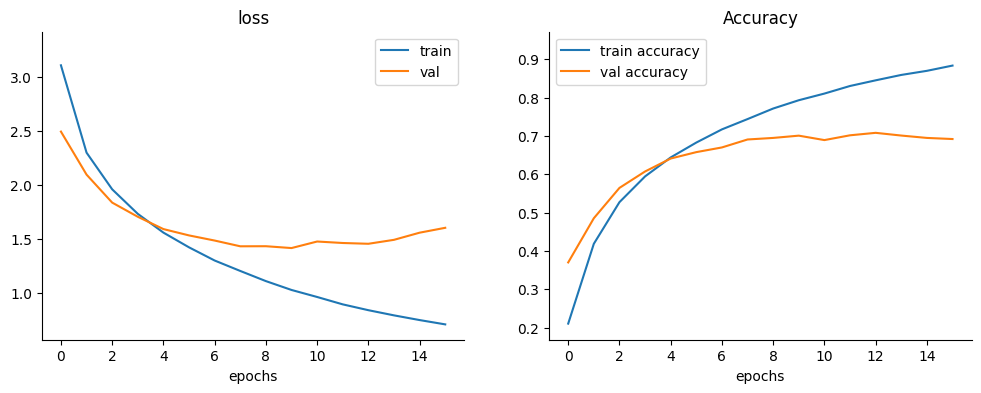

In [35]:
plot_history(history, 'accuracy', title='', axs=None, exp_name="")
plt.show()
